### Trying to make glass distributions to improve computation time

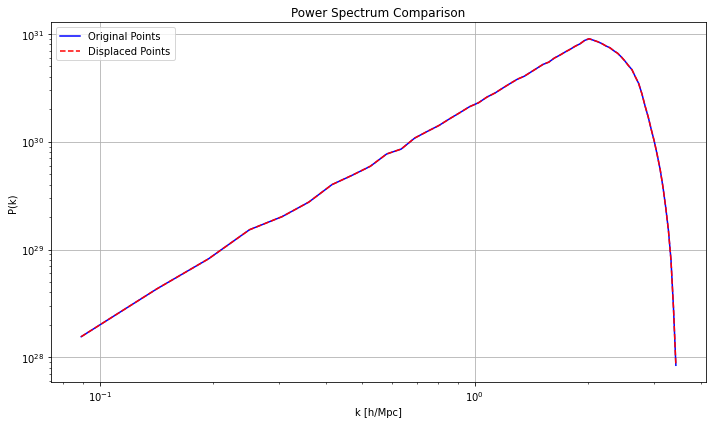

In [20]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftfreq
from scipy.interpolate import RegularGridInterpolator
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import matplotlib.pyplot as plt

def compute_zeldovich_displacements(grid_size, box_size, power_spectrum, redshift):
    # (Same as before)
    D_growth = cosmo.scale_factor(redshift)
    k = fftfreq(grid_size, d=box_size / grid_size) * 2 * np.pi
    kx, ky, kz = np.meshgrid(k, k, k, indexing="ij")
    k2 = kx**2 + ky**2 + kz**2
    k2[k2 == 0] = 1e-10
    delta_k = (np.random.normal(0, 1, (grid_size, grid_size, grid_size)) +
               1j * np.random.normal(0, 1, (grid_size, grid_size, grid_size)))
    delta_k *= np.sqrt(power_spectrum(np.sqrt(k2)))
    displacement_x_k = -1j * kx * delta_k / k2
    displacement_y_k = -1j * ky * delta_k / k2
    displacement_z_k = -1j * kz * delta_k / k2
    displacement_x = np.real(ifftn(displacement_x_k)) * D_growth
    displacement_y = np.real(ifftn(displacement_y_k)) * D_growth
    displacement_z = np.real(ifftn(displacement_z_k)) * D_growth
    displacements = np.stack([displacement_x, displacement_y, displacement_z], axis=0)
    return displacements

def apply_displacements_to_points(points, displacements, box_size):
    # (Same as before)
    grid_size = displacements.shape[1]
    grid_coords = np.linspace(0, box_size, grid_size)
    interpolators = [
        RegularGridInterpolator((grid_coords, grid_coords, grid_coords), displacements[i], bounds_error=False, fill_value=0)
        for i in range(3)
    ]
    interpolated_displacements = np.stack([interp(points) for interp in interpolators], axis=-1)
    displaced_points = points + interpolated_displacements
    return displaced_points

def calculate_power_spectrum(points, box_size, grid_size):
    """
    Calculate the power spectrum of a set of points.

    Parameters:
        points (ndarray): Array of points (N, 3).
        box_size (float): Size of the box in Mpc/h.
        grid_size (int): Number of grid cells along one dimension.

    Returns:
        k (ndarray): Wavenumbers.
        Pk (ndarray): Power spectrum values.
    """
    # Create a 3D density grid
    density_grid, _ = np.histogramdd(points, bins=grid_size, range=[[0, box_size]]*3)
    density_grid -= np.mean(density_grid)  # Subtract mean density
    density_grid /= (np.mean(density_grid)+1e-10)  # Divide by mean density

    # Fourier transform of the density field
    delta_k = fftn(density_grid)
    power_spectrum = np.abs(delta_k)**2

    # Compute k bins and average power spectrum
    grid = fftfreq(grid_size, box_size / grid_size) * 2 * np.pi
    kx, ky, kz = np.meshgrid(grid, grid, grid, indexing='ij')
    k = np.sqrt(kx**2 + ky**2 + kz**2).flatten()
    power_spectrum = power_spectrum.flatten()

    k_bins = np.linspace(0, np.max(k), grid_size // 2)
    Pk, _ = np.histogram(k, bins=k_bins, weights=power_spectrum)
    k_avg, _ = np.histogram(k, bins=k_bins, weights=k)

    k_avg = k_avg / np.maximum(np.histogram(k, bins=k_bins)[0], 1) #avoid division by zero
    return k_avg[1:], Pk[1:]  # Exclude the first bin (k=0)

# Parameters
grid_size = 128
box_size = 200.0  # Mpc/h
redshift = 0.5
num_points = 1000000

# Power spectrum function
def example_power_spectrum(k):
    return np.where(k > 0, k**-2, 0)

# Generate random points
random_points = np.random.uniform(0, box_size, (num_points, 3))

# Compute Zel'dovich displacements and apply them
displacements = compute_zeldovich_displacements(grid_size, box_size, example_power_spectrum, redshift)
displaced_points = apply_displacements_to_points(random_points, displacements, box_size)

# Calculate power spectra
k_original, Pk_original = calculate_power_spectrum(random_points, box_size, grid_size)
k_displaced, Pk_displaced = calculate_power_spectrum(displaced_points, box_size, grid_size)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.loglog(k_original, Pk_original, label='Original Points', color='blue')
plt.loglog(k_displaced, Pk_displaced, label='Displaced Points', color='red', linestyle='--')

n_mean = num_points / box_size**3
P_shot = 1 / n_mean
#plt.axhline(P_shot, color='gray', linestyle='--', label='Shot Noise')
#plt.axvline(2, color='gray', linestyle='-')

plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Create a distribution from a field that obeys P(k) = k^4

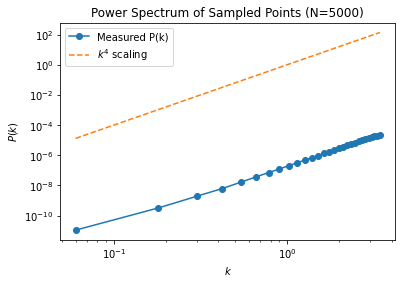

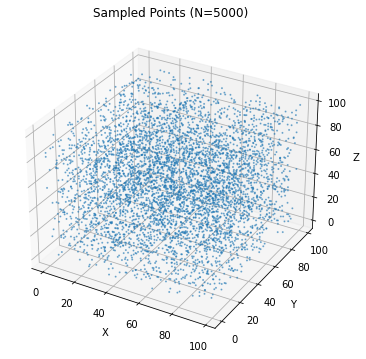

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 64  # Grid points per dimension
L = 100.0  # Box size
N_points = 5000  # Desired number of points

# Define k-space grid
k_freq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi  # Convert to physical k
kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
k = np.sqrt(kx**2 + ky**2 + kz**2)
k[0, 0, 0] = 1  # Avoid division by zero at k=0

# Generate random phases
random_phases = np.exp(2j * np.pi * np.random.rand(N, N, N))

# Apply power-law P(k) ~ k^4  ->  δ_k ~ k^2
delta_k = (k**2) * random_phases  
delta_k[k == 0] = 0  # Set mean mode to zero

# Transform back to real space
delta_x = np.fft.ifftn(delta_k).real

# Normalize the field
delta_x -= np.mean(delta_x)  # Zero mean
delta_x /= np.std(delta_x)   # Normalize variance

# **Sort voxels by density and pick N_points**
sorted_indices = np.argsort(delta_x.flatten())[::-1]  # Sort in descending order
top_indices = sorted_indices[:N_points]  # Keep only the top N_points

# Convert indices back to 3D positions
point_indices = np.column_stack(np.unravel_index(top_indices, (N, N, N)))
coords = point_indices * (L / N)  # Convert to real-space coordinates

# Compute power spectrum of the field
delta_k_fft = np.fft.fftn(delta_x) / N**3
Pk = np.abs(delta_k_fft)**2  # Power spectrum

# Bin P(k)
k_bins = np.linspace(0, np.max(k), 30)
k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
Pk_binned = np.zeros(len(k_bin_centers))
counts = np.zeros(len(k_bin_centers))

for i in range(N):
    for j in range(N):
        for l in range(N):
            k_val = k[i, j, l]
            bin_idx = np.digitize(k_val, k_bins) - 1
            if 0 <= bin_idx < len(Pk_binned):
                Pk_binned[bin_idx] += Pk[i, j, l]
                counts[bin_idx] += 1

Pk_binned /= counts  # Normalize

# Plot P(k)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_bin_centers, Pk_binned, 'o-', label="Measured P(k)")
ax.plot(k_bin_centers, k_bin_centers**4, '--', label=r"$k^4$ scaling")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_title(f"Power Spectrum of Sampled Points (N={N_points})")
ax.legend()
plt.show()

# Plot 3D scatter of extracted points
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=1, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"Sampled Points (N={N_points})")
plt.show()


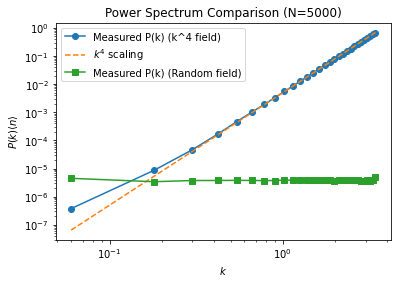

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 64  # Grid points per dimension
L = 100.0  # Box size
N_points = 5000  # Desired number of points

# Define k-space grid
k_freq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi  # Convert to physical k
kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
k = np.sqrt(kx**2 + ky**2 + kz**2)
k[0, 0, 0] = 1  # Avoid division by zero at k=0

# Generate random phases for the field with P(k) ~ k^4
random_phases = np.exp(2j * np.pi * np.random.rand(N, N, N))

# Apply power-law P(k) ~ k^4  ->  δ_k ~ k^2
delta_k = (k**2) * random_phases  
delta_k[k == 0] = 0  # Set mean mode to zero

# Transform back to real space
delta_x = np.fft.ifftn(delta_k).real

# Normalize the field
delta_x -= np.mean(delta_x)  # Zero mean
delta_x /= np.std(delta_x)   # Normalize variance

# Generate a random distribution in real space
random_distribution = np.random.rand(N, N, N)
random_distribution -= np.mean(random_distribution)  # Zero mean
random_distribution /= np.std(random_distribution)   # Normalize variance

# Compute the power spectrum of the random distribution
delta_k_random = np.fft.fftn(random_distribution) / N**3  # Normalized by grid size N^3
Pk_random = np.abs(delta_k_random)**2  # Power spectrum of random distribution

# Bin the power spectrum of the random field
k_bins = np.linspace(0, np.max(k), 30)
k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
Pk_random_binned = np.zeros(len(k_bin_centers))
counts_random = np.zeros(len(k_bin_centers))

# Binning loop for random field
for i in range(N):
    for j in range(N):
        for l in range(N):
            k_val = k[i, j, l]
            bin_idx = np.digitize(k_val, k_bins) - 1
            if 0 <= bin_idx < len(Pk_random_binned):
                Pk_random_binned[bin_idx] += Pk_random[i, j, l]
                counts_random[bin_idx] += 1

Pk_random_binned /= counts_random  # Normalize by the count of modes in each bin

# Bin the power spectrum of the P(k) ~ k^4 field
Pk_binned = np.zeros(len(k_bin_centers))
counts = np.zeros(len(k_bin_centers))

# Binning loop for k^4 field
for i in range(N):
    for j in range(N):
        for l in range(N):
            k_val = k[i, j, l]
            bin_idx = np.digitize(k_val, k_bins) - 1
            if 0 <= bin_idx < len(Pk_binned):
                Pk_binned[bin_idx] += np.abs(delta_k[i, j, l])**2
                counts[bin_idx] += 1

Pk_binned /= counts  # Normalize by the count of modes in each bin

# Calculate the mean density of the sample
mean_density = N_points / L**3

# Plot the power spectrum
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_bin_centers, Pk_binned * mean_density, 'o-', label="Measured P(k) (k^4 field)")
ax.plot(k_bin_centers, mean_density * k_bin_centers**4, '--', label=r"$k^4$ scaling")
ax.plot(k_bin_centers, Pk_random_binned, 's-', label="Measured P(k) (Random field)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k) \langle n \rangle$')
ax.set_title(f"Power Spectrum Comparison (N={N_points})")
ax.legend()
plt.show()


#### Con Deepseek

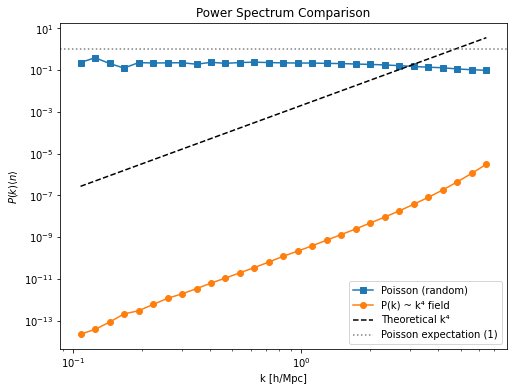

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 128              # Grid points per dimension
L = 100.0           # Box size (Mpc/h or similar units)
N_points = 2000     # Number of particles

# =================================================================
# Generate a Poisson point process (random particle positions)
# =================================================================
np.random.seed(42)  # For reproducibility
particle_positions = L * np.random.rand(N_points, 3)  # Positions in [0, L]

# =================================================================
# Cloud-in-Cell (CIC) mass assignment to grid
# =================================================================
def cic_window(kx, ky, kz, dx):
    """
    Compute the CIC window function correction for a 3D grid.
    """
    wx = np.sinc(kx * dx / (2 * np.pi))  # sinc(k Δx / 2π)
    wy = np.sinc(ky * dx / (2 * np.pi))
    wz = np.sinc(kz * dx / (2 * np.pi))
    return (wx * wy * wz)**2  # Squared for power spectrum correction

def cic_assign(positions, N, L):
    """
    Assign particles to a grid using 3D Cloud-in-Cell interpolation.
    Returns: density grid (not normalized)
    """
    grid = np.zeros((N, N, N), dtype=np.float32)
    dx = L / N  # Grid spacing
    
    for pos in positions:
        # Continuous grid coordinates (0 to N)
        x = pos[0] / dx
        y = pos[1] / dx
        z = pos[2] / dx
        
        # Integer indices of the cell containing the particle
        i = int(x)
        j = int(y)
        k = int(z)
        
        # Distance to the next grid point (for weights)
        dx1 = x - i
        dy1 = y - j
        dz1 = z - k
        dx0 = 1 - dx1
        dy0 = 1 - dy1
        dz0 = 1 - dz1
        
        # Wrap indices for periodic boundary conditions
        i0 = i % N
        i1 = (i + 1) % N
        j0 = j % N
        j1 = (j + 1) % N
        k0 = k % N
        k1 = (k + 1) % N
        
        # Distribute mass to 8 neighboring cells
        grid[i0, j0, k0] += dx0 * dy0 * dz0
        grid[i1, j0, k0] += dx1 * dy0 * dz0
        grid[i0, j1, k0] += dx0 * dy1 * dz0
        grid[i0, j0, k1] += dx0 * dy0 * dz1
        grid[i1, j1, k0] += dx1 * dy1 * dz0
        grid[i1, j0, k1] += dx1 * dy0 * dz1
        grid[i0, j1, k1] += dx0 * dy1 * dz1
        grid[i1, j1, k1] += dx1 * dy1 * dz1
    
    return grid

density_grid = cic_assign(particle_positions, N, L)

# =================================================================
# Compute density contrast for the Poisson field
# =================================================================
mean_density = N_points / L**3  # Particles per volume
density_contrast = (density_grid / mean_density) - 1  # δ = (ρ/⟨ρ⟩ - 1)

# =================================================================
# Generate the P(k) ~ k^4 Gaussian field
# =================================================================
# Define k-space grid (physical units)
k_freq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
k = np.sqrt(kx**2 + ky**2 + kz**2)
k[0, 0, 0] = 1  # Avoid division by zero

# Generate Gaussian field with P(k) ~ k^4
random_phases = np.exp(2j * np.pi * np.random.rand(N, N, N))
delta_k = (k**2) * random_phases  # δ_k ~ k^2 (since P(k) = |δ_k|^2 ~ k^4)
delta_k[0, 0, 0] = 0  # Zero mean mode

# Inverse FFT to real space
delta_x = np.fft.ifftn(delta_k).real
delta_x = delta_x - np.mean(delta_x)  # Ensure zero mean

# =================================================================
# Compute power spectra for both fields
# =================================================================
def compute_power_spectrum(density_field, L):
    N = density_field.shape[0]
    dx = L / N  # Grid spacing

    # Compute FFT and raw power spectrum
    delta_k = np.fft.fftn(density_field) / N**3
    Pk = np.abs(delta_k)**2 * L**3  # Raw P(k)

    # Define k grid (physical units)
    k_freq = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
    k = np.sqrt(kx**2 + ky**2 + kz**2)

    # Compute CIC window function
    window_cic = cic_window(kx, ky, kz, dx)
    window_cic[k == 0] = 1  # Avoid division by zero at k=0

    # Apply CIC correction
    Pk_corrected = Pk / window_cic

    # Bin the corrected power spectrum
    k_bins = np.geomspace(0.1, np.max(k), 30)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    Pk_binned = np.zeros_like(k_bin_centers)
    counts = np.zeros_like(k_bin_centers)

    for i in range(N):
        for j in range(N):
            for l in range(N):
                k_val = k[i, j, l]
                bin_idx = np.digitize(k_val, k_bins) - 1
                if 0 <= bin_idx < len(Pk_binned):
                    Pk_binned[bin_idx] += Pk_corrected[i, j, l]
                    counts[bin_idx] += 1
    Pk_binned /= counts
    return k_bin_centers, Pk_binned

# Compute power spectra
k_bins, Pk_poisson = compute_power_spectrum(density_contrast, L)
_, Pk_k4 = compute_power_spectrum(delta_x, L)

# =================================================================
# Plot results
# =================================================================
mean_density = N_points / L**3

plt.figure(figsize=(8, 6))
plt.plot(k_bins, Pk_poisson * mean_density, 's-', label='Poisson (random)')
plt.plot(k_bins, Pk_k4 * mean_density, 'o-', label='P(k) ~ k⁴ field')
plt.plot(k_bins, (k_bins**4) * mean_density, 'k--', label='Theoretical k⁴')

plt.axhline(1.0, color='gray', linestyle=':', label='Poisson expectation (1)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$P(k) \langle n \rangle$')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.show()

#### Just create random positions and plot P(k) calculated with nbodykit

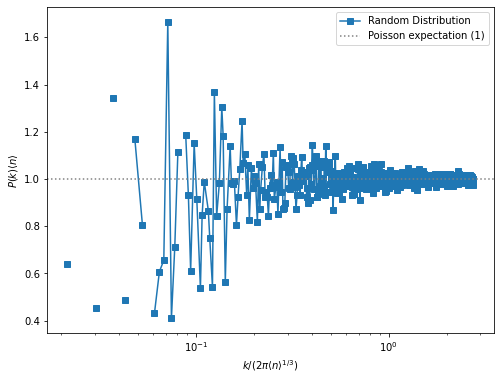

In [27]:
import numpy as np
from nbodykit.lab import ArrayCatalog, FFTPower

# Parameters
L = 100.0  # Box size
N_points = 100000  # Number of particles
nmean = N_points/L**3

# Generate particle positions
np.random.seed(42)
particle_positions = L * np.random.rand(N_points, 3)

# Create a catalog object
cat = ArrayCatalog({'Position': particle_positions})

# Convert to a mesh with CIC assignment (adjust Nmesh as needed)
mesh = cat.to_mesh(Nmesh=256, BoxSize=L, resampler='tsc', compensated=True)

# Compute the power spectrum
result = FFTPower(mesh, mode='1d', dk=.01, kmin=0.01)
Pk = result.power

# Plot
plt.figure(figsize=(8, 6))
plt.plot(Pk['k']/(2*np.pi*nmean**(1./3)), (Pk['power'].real)*nmean, 's-', label='Random Distribution')
plt.axhline(1.0, color='gray', linestyle=':', label='Poisson expectation (1)')
plt.xscale('log')
plt.xlabel(r'$k/(2\pi\langle n \rangle^{1/3})$')
plt.ylabel(r'$P(k)\langle n \rangle$')
plt.legend()
plt.show()

### Works! Now to add the computation of the P(k) of the k**4 distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nbodykit.lab import ArrayCatalog, FFTPower

# Parameters
L = 100           # Box size
N_points = 500_000   # Number of particles
Nmesh = 128        # Grid resolution
nmean = N_points / L**3  # Mean density

# =================================================================
# Generate a Gaussian field with P(k) ~ k^4
# =================================================================
def generate_k4_field(L, Nmesh, seed=42):
    """Generate a Gaussian random field with P(k) ~ k^4."""
    np.random.seed(seed)
    k_freq = np.fft.fftfreq(Nmesh, d=L/Nmesh) * 2 * np.pi
    kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
    k = np.sqrt(kx**2 + ky**2 + kz**2)
    k[0, 0, 0] = 1.0  # Avoid division by zero
    
    # Generate Gaussian field with P(k) ~ k^4
    phases = np.exp(2j * np.pi * np.random.rand(Nmesh, Nmesh, Nmesh))
    delta_k = (k**2) * phases  # δ_k ~ k² ⇒ P(k) = |δ_k|² ~ k⁴
    delta_k[0, 0, 0] = 0  # Zero mean mode
    
    # Inverse FFT to real space
    delta = np.fft.ifftn(delta_k).real
    return delta

# Generate the Gaussian field and normalize
delta = generate_k4_field(L, Nmesh)
delta = delta / np.std(delta)  # Normalize to unit variance

# =================================================================
# Sample particles deterministically (avoid log-normal and Poisson)
# =================================================================
# Rescale δ to ensure 1 + δ > 0 everywhere
delta_min = np.min(delta)
delta = delta - delta_min + 1e-6  # Ensure δ + offset > 0
rho = 1.0 + delta  # Density field ρ(x) = 1 + δ(x)

# Assign particles proportionally to ρ(x) using deterministic sampling
prob = rho.flatten() / np.sum(rho)
cumulative_prob = np.cumsum(prob)

# Generate deterministic particle indices
grid_indices = np.arange(Nmesh**3)
indices = np.searchsorted(cumulative_prob, np.linspace(0, 1, N_points, endpoint=False))
x, y, z = np.unravel_index(indices, (Nmesh, Nmesh, Nmesh))

# Convert grid indices to physical coordinates
positions = np.column_stack([
    (x + 0.5) * (L / Nmesh),
    (y + 0.5) * (L / Nmesh),
    (z + 0.5) * (L / Nmesh)
])

# =================================================================
# Compute power spectra
# =================================================================
def compute_power(positions, label, color):
    cat = ArrayCatalog({'Position': positions})
    mesh = cat.to_mesh(Nmesh=Nmesh, BoxSize=L, resampler='tsc', compensated=True)
    result = FFTPower(mesh, mode='1d', dk=0.05, kmin=0.001)
    Pk = result.power
    plt.plot(Pk['k'], Pk['power'].real, '-', color=color, label=label)
    return Pk

plt.figure(figsize=(8, 6))

# Plot Poisson catalog (for comparison)
particle_positions_poisson = L * np.random.rand(N_points, 3)
compute_power(particle_positions_poisson, 'Poisson (random)', 'C0')

# Plot k^4 catalog
Pk = compute_power(positions, r'$P(k) \sim k^4$', 'C1')

# Theoretical lines
k = np.logspace(-1, np.log10(3.0), 100) #/(np.pi*nmean**(1./3))
#plt.plot(k, (k**4), 'k--', label=r'Theoretical $k^4$')
plt.axhline(1./nmean, color='gray', linestyle=':', label='Poisson expectation (1)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k / (2\pi\langle n \rangle^{1/3}) \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \langle n \rangle$')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.show()

: 

In [9]:
np.nanmin(Pk['k'])

0.08899641323548096